# 1. Notebook Styling and Library Installation
You can ignore this cell and move to library imports.

In [331]:
import IPython
from IPython.display import display, HTML, SVG, Image
import graphviz
from graphviz import Source
from io import StringIO
import matplotlib.pyplot as plt
import pydotplus
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import * 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from category_encoders import *
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from pandas import DataFrame

pd.set_option('display.max_rows', 500)

shap.initjs()

def displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, title):
    PLOT_FONT_SIZE = 14
    plt.rcParams['figure.figsize'] = [5, 5]
    confusionMatrix = np.transpose(confusionMatrix)
    plt.imshow(confusionMatrix, interpolation='nearest',cmap=plt.cm.Blues, vmin=0, vmax=100)
    xticks = np.array([-0.5, 0, 1,1.5])
    plt.gca().set_xticks(xticks)
    plt.gca().set_yticks(xticks)
    plt.gca().set_xticklabels(["", "Leave\nRecall=" + str(recallNegative) , "Stay\nRecall=" + str(recallPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.gca().set_yticklabels(["", "Leave\nPrecision=" + str(precisionNegative) , "Stay\nPrecision=" + str(precisionPositive), ""], fontsize=PLOT_FONT_SIZE)
    plt.ylabel("Predicted Class", fontsize=PLOT_FONT_SIZE)
    plt.xlabel("Actual Class", fontsize=PLOT_FONT_SIZE)
    plt.title(title, fontsize=PLOT_FONT_SIZE)
    for i in range(2):
        for j in range(2):
            text = plt.text(j, i, confusionMatrix[i][j], ha="center", va="center", color="white", size=15)            
    plt.show()


def calculateMetricsAndPrint(predictions, predictionsProbabilities, actualLabels):
    predictionsProbabilities = [item[1] for item in predictionsProbabilities]
    accuracy = round(accuracy_score(actualLabels, predictions) * 100, 2)
    precisionNegative = round(precision_score(actualLabels, predictions, average = None)[0] * 100, 2)
    precisionPositive = round(precision_score(actualLabels, predictions, average = None)[1] * 100, 2)
    recallNegative = round(recall_score(actualLabels, predictions, average = None)[0] * 100, 2)
    recallPositive = round(recall_score(actualLabels, predictions, average = None)[1] * 100, 2)
    auc = round(roc_auc_score(actualLabels, predictionsProbabilities) * 100, 2)
    confusionMatrix = confusion_matrix(actualLabels, predictions)
    print("Accuracy: %.2f\nPrecisionNegative: %.2f\nPrecisionPositive: %.2f\nRecallNegative: %.2f\nRecallPositive: %.2f\nAUC Score: %.2f\n" % 
          (accuracy, precisionNegative, precisionPositive, recallNegative, recallPositive, auc))
    displayConfusionMatrix(confusionMatrix, precisionNegative, precisionPositive, recallNegative, recallPositive, "Confusion Matrix")
    return auc

def showFeatureImportance(classifier, columns):
    columns = columns[1:]
    plt.rcParams['figure.figsize'] = [16, 6]
    PLOT_FONT_SIZE = 14
    featureImportance = classifier.feature_importances_
    featureImportanceWithColumns = list(reversed(sorted([[featureImportance[i], columns[i]] for i in range(0, len(columns))])))
    sortedColumns = [item[1] for item in featureImportanceWithColumns]
    sortedFeatures = [item[0] for item in featureImportanceWithColumns]
    xaxis = np.arange(len(featureImportance))
    plt.bar(xaxis, sortedFeatures, width = 0.5, color = 'white', hatch = '//', edgecolor = '#8a4191', linewidth = 2.0)
    plt.xticks(xaxis, sortedColumns, fontsize = PLOT_FONT_SIZE, rotation = 45)
    plt.yticks(fontsize = PLOT_FONT_SIZE)
    plt.xlabel("Feature Name",fontsize = PLOT_FONT_SIZE)
    plt.ylabel("Feature Importance",fontsize = PLOT_FONT_SIZE)
    plt.title("Feature Importances", fontsize = PLOT_FONT_SIZE)
    plt.show()
    importanceDataFrame = pd.DataFrame(featureImportanceWithColumns)
    display(importanceDataFrame)

In [305]:
data = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Train.csv", ","))
data = data.dropna()
columns = list(data.columns)
testDataForSubmission = pd.DataFrame(pd.read_csv("Data/HiltonPredictionData_Test.csv", ","))
testDataForSubmission = testDataForSubmission.dropna()
data.head()
data.shape

(4800, 16)

In [306]:
# Return # of 5 ratings (or 4 if >4)
def num_5point (row):
    counter=0
    if row['RewardsBenefits'] == 5 :
        counter = counter+ 1
    if row['WorkEnvironment'] == 5:
        counter = counter+ 1
    if row['WorkLifeBalance'] == 5 :
        counter = counter+ 1
    if row['Communication'] == 5 :
        counter = counter+ 1
    if row['Voice'] == 5 :
        counter = counter+ 1
    if row['LearningDevelopment'] == 5 :
        counter = counter+ 1
    if counter>=4:
        return 4
    return counter

# Return minimum rating of top 3 most important
def minCat (row):
    minPIV =  min(row['RewardsBenefits'],
    row['WorkEnvironment'],
    row['WorkLifeBalance'])
    if minPIV <4.5 :
        return 0
    if minPIV  <5 :
        return 1
    return 2

#Return 1 if all 5s
def all5 (row):
    minPIV =  min(row['RewardsBenefits'],
    row['WorkEnvironment'],
    row['WorkLifeBalance'],
    row['Communication'],
    row['Voice'],
    row['LearningDevelopment'])
    if minPIV ==5:
        return 1
    else:
        return 0

def has_1point (row):
    counter=0
    if row['RewardsBenefits'] in [1,2,3] :
        counter = counter+ 1
    if row['WorkEnvironment']  in [1,2,3] :
        counter = counter+ 1
    if row['WorkLifeBalance']  in [1,2,3] :
        counter = counter+ 1
    if row['Communication'] in [1,2] :
        counter = counter+ 1
    if row['Voice']  in [1,2] :
        counter = counter+ 1
    if row['LearningDevelopment'] in [1,2]  :
        counter = counter+ 1
    # return counter
    if counter >=2:
        return 0
    return 1
    # return 2

def has_123point (row):
    counter=0
    if row['RewardsBenefits'] in [1,2,3] :
        counter = counter+ 1
    if row['WorkEnvironment']  in [1,2,3] :
        counter = counter+ 1
    if row['WorkLifeBalance']  in [1,2,3] :
        counter = counter+ 1
    if row['Communication'] in [1,2,3] :
        counter = counter+ 1
    if row['Voice']  in [1,2,3] :
        counter = counter+ 1
    if row['LearningDevelopment'] in [1,2,3]  :
        counter = counter+ 1
    if counter==0:
        return 2
    if counter ==1:
        return 1
    return 0

def workEnv (row):
    if row['WorkEnvironment'] <4.5 :
        return 0
    if row['WorkEnvironment']  <5 :
        return 1
    return 2

def RewardsBenefits (row):
    if row['RewardsBenefits'] <4.5 :
        return 0
    if row['RewardsBenefits']  <5 :
        return 1
    return 2

def WorkLifeBalance (row):
    if row['WorkLifeBalance'] <4.5 :
        return 0
    if row['WorkLifeBalance']  <5 :
        return 1
    return 2

def ld_mutate (row):
    if row['LearningDevelopment'] <4.5 :
        return 0
    if row['LearningDevelopment']  <5 :
        return 1
    return 2


###
def comm_mutate (row):
    if row['Communication'] <4.5 :
        return 0
    if row['Communication']  <5 :
        return 1
    return 2


def voice_mutate (row):
    if row['Voice'] <4.5 :
        return 0
    if row['Voice']  <5 :
        return 1
    return 2

def ten (row):
    if row['Tenure'] in [5,6,3] :
        return 0
    if row['Tenure']  in [2,7,4] :
        return 1
    return 2

def gen (row):
    if row['Generation'] in [1] :
        return 0
    # if row['Generation']  in [2,7,4] :
    #     return 1
    return 1

def dep (row):
    if row['Department'] in [37,40,37,40,38,19,34,27,31,3 ,26,25,15] :
        return 0
    if row['Department']  in [39,33,7 ,29,5 ,36,16,8 ,12,28,20] :
        return 1
    if row['Department']  in [21,22,41,18,17,10,24,9 ] :
        return 2
    return 3


def mgmt (row):
    if row['ManagementLevel'] in [4] :
        return 0
    if row['ManagementLevel']  in [1,2] :
        return 1
    if row['ManagementLevel']  in [3] :
        return 2
    return 3

data['dep'] = data.apply (lambda row: dep(row), axis=1)
testDataForSubmission['dep'] = testDataForSubmission.apply (lambda row: dep(row), axis=1)

data['mgmt'] = data.apply (lambda row: mgmt(row), axis=1)
testDataForSubmission['mgmt'] = testDataForSubmission.apply (lambda row: mgmt(row), axis=1)

data['ten'] = data.apply (lambda row: ten(row), axis=1)
testDataForSubmission['ten'] = testDataForSubmission.apply (lambda row: ten(row), axis=1)

data['gen'] = data.apply (lambda row: gen(row), axis=1)
testDataForSubmission['gen'] = testDataForSubmission.apply (lambda row: gen(row), axis=1)

data['voice'] = data.apply (lambda row: voice_mutate(row), axis=1)
testDataForSubmission['voice'] = testDataForSubmission.apply (lambda row: voice_mutate(row), axis=1)
data['comm'] = data.apply (lambda row: comm_mutate(row), axis=1)
testDataForSubmission['comm'] = testDataForSubmission.apply (lambda row: comm_mutate(row), axis=1)
data['ld'] = data.apply (lambda row: ld_mutate(row), axis=1)
testDataForSubmission['ld'] = testDataForSubmission.apply (lambda row: ld_mutate(row), axis=1)
data['workEnv'] = data.apply (lambda row: workEnv(row), axis=1)
testDataForSubmission['workEnv'] = testDataForSubmission.apply (lambda row: workEnv(row), axis=1)
data['money'] = data.apply (lambda row: RewardsBenefits(row), axis=1)
testDataForSubmission['money'] = testDataForSubmission.apply (lambda row: RewardsBenefits(row), axis=1)
data['wlb'] = data.apply (lambda row: WorkLifeBalance(row), axis=1)
testDataForSubmission['wlb'] = testDataForSubmission.apply (lambda row: WorkLifeBalance(row), axis=1)



data['all5'] = data.apply (lambda row: all5(row), axis=1)
testDataForSubmission['all5'] = testDataForSubmission.apply (lambda row: all5(row), axis=1)

data['num5'] = data.apply (lambda row: num_5point(row), axis=1)
testDataForSubmission['num5'] = testDataForSubmission.apply (lambda row: num_5point(row), axis=1)

data['mincat'] = data.apply (lambda row: minCat(row), axis=1)
testDataForSubmission['mincat'] = testDataForSubmission.apply (lambda row: minCat(row), axis=1)

data['has1'] = data.apply (lambda row: has_1point(row), axis=1)
testDataForSubmission['has1'] = testDataForSubmission.apply (lambda row: has_1point(row), axis=1)

data['has123'] = data.apply (lambda row: has_123point(row), axis=1)
testDataForSubmission['has123'] = testDataForSubmission.apply (lambda row: has_123point(row), axis=1)


inspectDept = data[['HotelInncode', 'IntentToStay']]
data['badinn'] = 0
testDataForSubmission['badinn'] = 0
y = inspectDept.groupby(['HotelInncode']).mean().sort_values('IntentToStay').reset_index()
for index, row in y.iterrows():
    if row.IntentToStay <= .35:
        # print(index)
        data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 0
        testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 0
    elif row.IntentToStay <= .50:
        # print(index)
        data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 1
        testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 1
    elif row.IntentToStay <= .60:
        # print(index)
        data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 2
        testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 2
    elif row.IntentToStay <= .70:
        # print(index)
        data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 3
        testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 3
    else:
        # print(index)
        data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 4
        testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 4
    # elif row.IntentToStay <= .6:
    #     # print(index)
    #     data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 6
    #     testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 6
    # elif row.IntentToStay <= .7:
    #     # print(index)
    #     data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 7
    #     testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 7
    # elif row.IntentToStay <= .8:
    #     # print(index)
    #     data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 8
    #     testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 8
    # elif row.IntentToStay <= .9:
    #     # print(index)
    #     data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 9
    #     testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 9
    # else:
    #     # print(index)
    #     data.loc[data.HotelInncode == row.HotelInncode, "badinn"] = 10
    #     testDataForSubmission.loc[testDataForSubmission.HotelInncode == row.HotelInncode, "badinn"] = 10



In [307]:
#             IntentToStay
# HotelBrand              
# 10              0.416667
# 9               0.484375
# 8               0.500000
# 5               0.529801
# 11              0.539437
# 1               0.548673
# 6               0.549229
# 4               0.550102
# 3               0.554604
# 2               0.557692
# 7               0.588235


# % of data:
#             IntentToStay
# HotelBrand              
# 1               0.023542
# 2               0.043333
# 3               0.097292
# 4               0.101875
# 5               0.031458
# 6               0.526875
# 7               0.003542
# 8               0.000833
# 9               0.013333
# 10              0.010000
# 11              0.147917
# 4800
        

#                  IntentToStay
# HotelChainScale              
# 5                    0.416667
# 1                    0.529032
# 4                    0.540705
# 2                    0.547445
# 3                    0.549907


# % of data:
#                  IntentToStay
# HotelChainScale              
# 1                    0.032292
# 2                    0.114167
# 3                    0.672083
# 4                    0.171458
# 5                    0.010000
# 4800
#  'dep',
#  'mgmt',
#  'ten',
#  'gen',
#  'voice',
#  'comm',
#  'ld',
#  'workEnv',
#  'money',
#  'wlb',
#  'all5',
#  'num5',
#  'mincat',
#  'has1'

In [308]:
varToInspect = 'has1'
num=data.shape[0]
inspect = data[[varToInspect, 'IntentToStay']]
x=inspect.groupby(by=varToInspect).mean().sort_values('IntentToStay', ascending=True)
# x=inspect.groupby([varToInspect,'Department']).mean().sort_values('IntentToStay', ascending=True)

print(x)

print("\n\n% of data:")
print(inspect.groupby(by=[varToInspect]).count()/num)
# print(inspect.groupby([varToInspect,'Department']).count()/num)
# df.groupby(by=["B", "C"]).aggregate(pd.np.sum)
num

      IntentToStay
has1              
0         0.119681
1         0.582278


% of data:
      IntentToStay
has1              
0         0.078333
1         0.921667


4800

In [309]:
first_col= data.pop("IntentToStay")



# encoder = OneHotEncoder(cols=[
#  'has123']).fit(data)
# data = encoder.transform(data)
# testDataForSubmission = encoder.transform(testDataForSubmission)
data.insert(0,'IntentToStay',first_col)

In [310]:
columns = list(data.columns)
columnst = list(testDataForSubmission.columns)
print(len(columns)-1==len(columnst))
columns


True


['IntentToStay',
 'AnonymousID',
 'HotelInncode',
 'HotelBrand',
 'HotelChainScale',
 'Generation',
 'Department',
 'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'dep',
 'mgmt',
 'ten',
 'gen',
 'voice',
 'comm',
 'ld',
 'workEnv',
 'money',
 'wlb',
 'all5',
 'num5',
 'mincat',
 'has1',
 'has123',
 'badinn']

In [311]:
columns
keep = [
#  'WorkLifeBalance',
#  'LearningDevelopment',
#  'Communication',
#  'Voice',
#  'RewardsBenefits',
#  'WorkEnvironment',
 'dep',
 'mgmt',
 'ten',
 'gen',
 'voice',
 'comm',
 'ld',
 'workEnv',
 'money',
 'wlb',
 'all5',
 'num5',
 'mincat',
 'has1',
 'has123']


keep = [
'FullTimePartTime',
 'Tenure',
 'ManagementLevel',
 'WorkLifeBalance',
 'LearningDevelopment',
 'Communication',
 'Voice',
 'RewardsBenefits',
 'WorkEnvironment',
 'dep',
 'mgmt',
 'ten',
 'gen',
 'voice',
 'comm',
 'ld',
 'workEnv',
 'money',
 'wlb',
 'all5',
 'num5',
 'mincat',
 'has1',
 'has123',
 'badinn']

In [312]:
# for var in keep:
#     num=data.shape[0]
#     inspect = data[[var, 'IntentToStay']]
#     x=inspect.groupby(by=var).mean().sort_values('IntentToStay', ascending=True)
#     print(x)
#     print('% data')
#     print(inspect.groupby(by=[var]).count()/num)
#     print('------------')


# Make test data

In [313]:
columns = list(data.columns)
# The indicies we are using from the original data DF
indicies = []
for x in keep:
    indicies.append(columns.index(x))
print(indicies)

dataList = data.values.tolist()
features = []

for row in dataList:
    featureValues=[]

    for i in indicies:
        featureValues.append(row[i])
    
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    features.append(featureValues)
    
labels = [row[0] for row in dataList]
print("Label distribution of 0 and 1", labels.count(0), labels.count(1))

[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Label distribution of 0 and 1 2179 2621


In [314]:
TEST_DATA_PERCENTAGE = 0.2
first_col= data.pop("IntentToStay")
# print(data.head())
data.insert(0,'IntentToStay',first_col)
data.head()
trainData, testData, trainLabels, testLabels = train_test_split(features, labels, test_size=TEST_DATA_PERCENTAGE)

In [315]:
forCor = data.columns.isin(keep)
forCor[0] = True 
columns = data.iloc[:,forCor].columns
columns

Index(['IntentToStay', 'FullTimePartTime', 'Tenure', 'ManagementLevel',
       'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice',
       'RewardsBenefits', 'WorkEnvironment', 'dep', 'mgmt', 'ten', 'gen',
       'voice', 'comm', 'ld', 'workEnv', 'money', 'wlb', 'all5', 'num5',
       'mincat', 'has1', 'has123', 'badinn'],
      dtype='object')

Accuracy: 82.08
PrecisionNegative: 78.46
PrecisionPositive: 85.54
RecallNegative: 83.83
RecallPositive: 80.61
AUC Score: 90.15



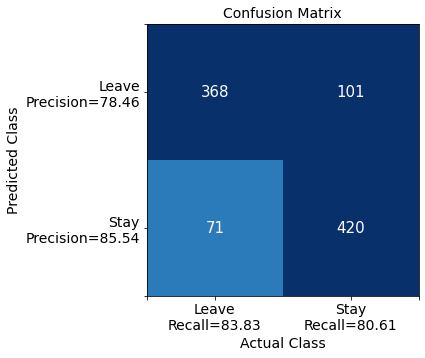

In [316]:
gbClassifier =GradientBoostingClassifier(learning_rate=0.25, max_depth=6, max_features='sqrt',
                           min_samples_leaf=70, n_estimators=30, random_state=77)
gbClassifier.fit(trainData, trainLabels)
trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData) 
predictionProbabilities = gbClassifier.predict_proba(testData)
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)
falsePositiveRateGB, truePositiveRateGB, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [317]:
columns

Index(['IntentToStay', 'FullTimePartTime', 'Tenure', 'ManagementLevel',
       'WorkLifeBalance', 'LearningDevelopment', 'Communication', 'Voice',
       'RewardsBenefits', 'WorkEnvironment', 'dep', 'mgmt', 'ten', 'gen',
       'voice', 'comm', 'ld', 'workEnv', 'money', 'wlb', 'all5', 'num5',
       'mincat', 'has1', 'has123', 'badinn'],
      dtype='object')

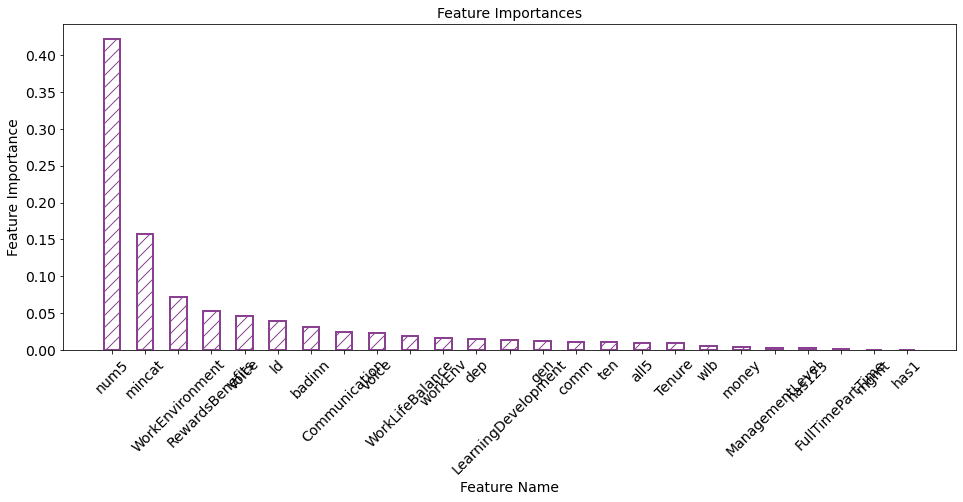

,0,1
0,0.421083,num5
1,0.156746,mincat
2,0.071485,WorkEnvironment
3,0.053344,RewardsBenefits
4,0.046315,Voice
5,0.040124,ld
6,0.030893,badinn
7,0.024057,Communication
8,0.022605,voice
9,0.019536,WorkLifeBalance


In [318]:
showFeatureImportance(gbClassifier, columns)

Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Accuracy: 83.23
PrecisionNegative: 79.45
PrecisionPositive: 86.89
RecallNegative: 85.42
RecallPositive: 81.38
AUC Score: 90.59



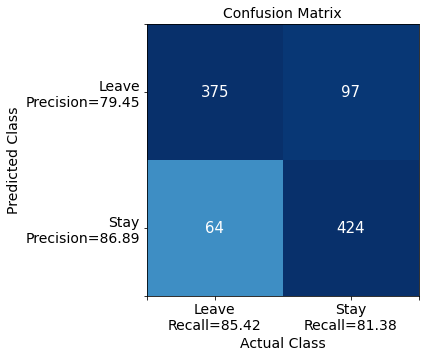

In [319]:
parameters = {'loss': ["deviance", "exponential"],
            'max_depth': [3, 5,7,9],
            'min_impurity_decrease': [0,.1,.05],
            'learning_rate': [.005,0.1,0.15],
            'n_estimators': [50,250,350],
            'max_features':['None',.8,.6],
            'subsample': [.6,.75,1.0]} 
gbClassifierWithGridSearch = GridSearchCV(GradientBoostingClassifier(),scoring='roc_auc', cv=5, param_grid=parameters, n_jobs=10, verbose=1)
gbClassifierWithGridSearch.fit(trainData, trainLabels)
gbClassifier= gbClassifierWithGridSearch.best_estimator_
gbClassifier.fit(trainData, trainLabels)

trainAccuracy = gbClassifier.score(trainData, trainLabels)
predictions = gbClassifier.predict(testData) 
predictionProbabilities = gbClassifier.predict_proba(testData) 
gbtGridAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)
falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Accuracy: 81.98
PrecisionNegative: 78.54
PrecisionPositive: 85.22
RecallNegative: 83.37
RecallPositive: 80.81
AUC Score: 90.07



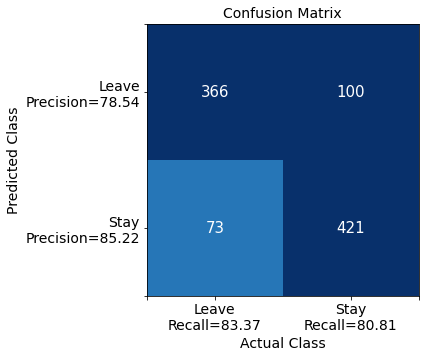

RandomForestClassifier(ccp_alpha=0.0005, max_depth=5, max_features=0.7,
                       min_impurity_decrease=0, min_samples_leaf=6,
                       n_estimators=25, random_state=201)


In [330]:
# RandomForestClassifier(ccp_alpha=0.0005, max_depth=6, max_features=0.7,
#                        min_impurity_decrease=0, min_samples_leaf=8,
#                        n_estimators=15, random_state=201)
parameters = {'max_depth': [5,6,7],
            'min_impurity_decrease': [0],
            'n_estimators': [15,25,35],
            'max_features':['auto',.8,.7],
             'min_samples_leaf': [6,7,8],
            'ccp_alpha': [.0005,.001,.01]} 

rf_tuned = GridSearchCV(RandomForestClassifier(random_state=201),param_grid=parameters, cv=5, n_jobs=6, verbose=1).fit(trainData, trainLabels)
rfClassifier = rf_tuned.best_estimator_
rfClassifier.fit(trainData, trainLabels)

predictions = rfClassifier.predict(testData)
predictionProbabilities = rfClassifier.predict_proba(testData)
rfAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)
falsePositiveRateRF, truePositiveRateRF, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
print(rf_tuned.best_estimator_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Accuracy: 82.92
PrecisionNegative: 79.70
PrecisionPositive: 85.92
RecallNegative: 84.05
RecallPositive: 81.96
AUC Score: 89.79



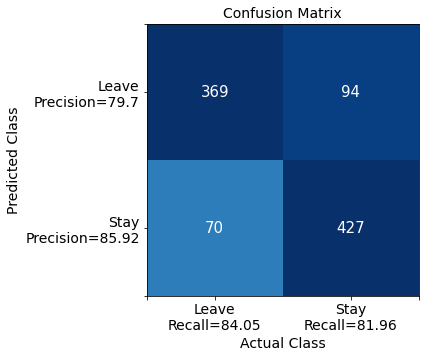

In [334]:
xdf = DataFrame(trainData)
ydf = DataFrame(trainLabels, columns=['IntentToStay'])
xTestdf = DataFrame(testData)
yTestdf = DataFrame(testLabels, columns=['IntentToStay'])

xg = XGBClassifier(objective="binary:logistic")
param_grid = {'max_depth': [4,6,10],
'n_estimators': [10, 20],
'min_child_weight' :[1,.8],
'gamma': [0,.1,.8],
'subsample': [1,.8],
'lambda': [1,.8],
'alpha' : [0,.2]}
scorer = make_scorer(recall_score, pos_label="yes") # We are optimizing based on recall of 'yes' clas

tuned = GridSearchCV(xg, param_grid, cv=5, verbose=1, n_jobs=-1).fit(xdf, ydf)
xg = tuned.best_estimator_
xg.fit(xdf, ydf)
predictions = xg.predict(xTestdf)
predictionProbabilities = xg.predict_proba(xTestdf)
XGBCAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, yTestdf)
falsePositiveRateXGB, truePositiveRateXGB, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])

In [339]:
 param_grid = {'C': np.logspace(.1, 10, 1),  
                'gamma': [ 0.1, 0.01,1 ], 
                'kernel': ['linear' ]}  
    
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose=5, n_jobs=10) 
grid.fit(trainData, trainLabels)
myLinearSVC=grid.best_estimator_



TypeError: __init__() got an unexpected keyword argument 'probability'

In [ ]:
myLinearSVC = SVC(C=1.2589254117941673, gamma=0.1, kernel='linear', probability=True)
myLinearSVC.fit(trainData, trainLabels)
predictions = myLinearSVC.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = myLinearSVC.predict_proba(testData)
linearSvcAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)
falsePositiveRateSVC, truePositiveRateSVC, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])


In [ ]:
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors':[5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}
kNmodelCV = GridSearchCV(kNmodel, param_grid=params, verbose=3, n_jobs=10).fit(trainData, trainLabels)

knnModel = kNmodelCV.best_estimator_
knnModel.fit(trainData, trainLabels)

predictions = knnModel.predict(testData)
print(classification_report(testLabels, predictions)) 
predictionProbabilities = knnModel.predict_proba(testData)
knnAUC = calculateMetricsAndPrint(predictions, predictionProbabilities, testLabels)
falsePositiveRateLinearKNN, truePositiveRateLinearKNN, _ = roc_curve(testLabels, [item[1] for item in predictionProbabilities])
print(kNmodelCV.best_estimator_)


In [ ]:
plt.rcParams['figure.figsize'] = [16, 8]
FONT_SIZE = 17

# plt.plot(falsePositiveRateDt, truePositiveRateDt, linewidth = 3, label = "DecisionTree(DT)")
# plt.plot(falsePositiveRateDtWithGridSearch, truePositiveRateDtWithGridSearch, linewidth = 3, label = "DTWithGridSearch")
# plt.plot(falsePositiveRateGb, truePositiveRateGb, linewidth = 3, label = "GradientBoostedTrees(GBT)")
plt.plot([0,1],[0,1], 'k--')
plt.plot(falsePositiveRateGbWithGridSearch, truePositiveRateGbWithGridSearch, linewidth = 5, label = "GBT " + str(gbtGridAUC), linestyle='--')
plt.plot(falsePositiveRateXGB, truePositiveRateXGB, linewidth = 5, label = "XGB " + str(XGBCAUC), linestyle='--')
plt.plot(falsePositiveRateLinearKNN, truePositiveRateLinearKNN, linewidth = 3, label = "KNN " + str(knnAUC), linestyle='--')
plt.plot(falsePositiveRateRF, truePositiveRateRF, linewidth = 3, label = "Random Forrest " + str(rfAUC), alpha=.7, linestyle='--')
plt.plot(falsePositiveRateSVC, truePositiveRateSVC, linewidth = 3, label = "Linear SVC " + str(linearSvcAUC), alpha=.7, linestyle='--')
plt.legend(fontsize=FONT_SIZE)
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.xlabel("False Positive Rate", fontsize=FONT_SIZE)
plt.ylabel("True Positive Rate", fontsize=FONT_SIZE)
plt.show()

In [ ]:
columns = list(testDataForSubmission.columns)
# The indicies we are using from the original data DF
indicies = []
for x in keep:
    print(x)
    indicies.append(columns.index(x))
print(indicies)

testDataListForSubmission = testDataForSubmission.values.tolist()

# Get features
testFeaturesForSubmission = []

# Iterate over each row
for row in testDataListForSubmission:
    
    # Skip the first two columns because they are not needed and the last column because that's the label
    featureValues = []
    for i in indicies:
        featureValues.append(row[i])
    # Replace NULL values with 0. Using an if-else statement within a list is called list comprehension
    featureValues = [float(value) if value != "#NULL!" else 0 for value in featureValues] 
    
    # Append the features to the feature list
    testFeaturesForSubmission.append(featureValues)



In [ ]:
#GBC
resultsFile = open("Results/gbPredictionsGssrid77.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()


In [ ]:

#RF
resultsFile = open("Results/RFPredictionsGrid77.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(rfClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

#SVC
resultsFile = open("Results/SVC.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(myLinearSVC.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

#XGBC
submitXDF = DataFrame(testFeaturesForSubmission)
resultsFile = open("Results/XG.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(xg.predict_proba(submitXDF), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()
    
#KNN
resultsFile = open("Results/KNN.csv", "w")
resultsFile.write("Id,Expected\n")
for predictionProb, i in zip(knnModel.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str(float(predictionProb[1])) + "\n")
resultsFile.close()

# Ensemble
resultsFile = open("Results/rf_gb_new.csv", "w")
resultsFile.write("Id,Expected\n")
for gbPredictionProb, rfPredictionProb, i in zip(gbClassifier.predict_proba(testFeaturesForSubmission), rfClassifier.predict_proba(testFeaturesForSubmission), np.arange(len(testFeaturesForSubmission))):
    resultsFile.write(str(i + 1) + "," + str((float(gbPredictionProb[1])+float(rfPredictionProb[1]))/2) + "\n")
resultsFile.close()

print("All predictions have been placed in the results folder...")